# Distribution of Public Charging Stations
Look at how public charging stations are distributed geographically:
* See what other types of businesses are clustered around the stations, and if these are zipcode-specific
* Create economic-based clusters and compare that to distance-based clusters
* Evaluate long-distance travel ability


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import folium
import json, requests
from datetime import datetime
import time
import geocoder
from geopy.geocoders import Nominatim
from geopy import distance
import pickle

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
matplotlib.style.use('ggplot')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
stations = pd.read_csv('./Data/alt_fuel_stations (Mar 23 2021).csv')

# extract stations in WA state
stations = stations[stations['State']=='WA']

# convert camelcase to snakecase
stations.columns = stations.columns.str.lower()
stations.rename(columns=lambda c: c.replace(' ','_'), inplace=True)

stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610 entries, 112 to 44772
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fuel_type_code                    1610 non-null   object 
 1   station_name                      1610 non-null   object 
 2   street_address                    1610 non-null   object 
 3   intersection_directions           123 non-null    object 
 4   city                              1610 non-null   object 
 5   state                             1610 non-null   object 
 6   zip                               1610 non-null   object 
 7   plus4                             0 non-null      float64
 8   station_phone                     1463 non-null   object 
 9   status_code                       1610 non-null   object 
 10  expected_date                     1 non-null      object 
 11  groups_with_access_code           1610 non-null   object 
 12  acc

/Users/aida/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3,6,10,13,20,29,31,32,45,46,47,54,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
stations.columns

Index(['fuel_type_code', 'station_name', 'street_address',
       'intersection_directions', 'city', 'state', 'zip', 'plus4',
       'station_phone', 'status_code', 'expected_date',
       'groups_with_access_code', 'access_days_time', 'cards_accepted',
       'bd_blends', 'ng_fill_type_code', 'ng_psi', 'ev_level1_evse_num',
       'ev_level2_evse_num', 'ev_dc_fast_count', 'ev_other_info', 'ev_network',
       'ev_network_web', 'geocode_status', 'latitude', 'longitude',
       'date_last_confirmed', 'id', 'updated_at', 'owner_type_code',
       'federal_agency_id', 'federal_agency_name', 'open_date',
       'hydrogen_status_link', 'ng_vehicle_class', 'lpg_primary',
       'e85_blender_pump', 'ev_connector_types', 'country',
       'intersection_directions_(french)', 'access_days_time_(french)',
       'bd_blends_(french)', 'groups_with_access_code_(french)',
       'hydrogen_is_retail', 'access_code', 'access_detail_code',
       'federal_agency_code', 'facility_type', 'cng_dispenser_n

First, deal with city names:
* convert all to uppercase 1st letter only (.title)
* consolidate the following cities:
    * Sea Tac -> Seatac
    * Mt Vernon, Mt. Vernon -> Mount Vernon

In [5]:
stations['city'] = stations['city'].str.title()

stations.loc[stations.city == 'Sea Tac', ['city']] = 'Seatac'
stations.loc[stations.city == 'Mt Vernon', ['city']] = 'Mount Vernon'
stations.loc[stations.city == 'Mt. Vernon', ['city']] = 'Mount Vernon'

In [62]:
# convert 'zip' to type int
stations['zip'] = stations['zip'].astype(int)

# initialize to None
lat_lng_coords = None

# loop until we get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('Ellensburg, Washington') # center the map around the middle of WA state
    lat_lng_coords = g.latlng

latitude_wa = lat_lng_coords[0]
longitude_wa = lat_lng_coords[1]

print('The geograpical coordinate of Ellensburg are {}, {}.'.format(latitude_wa, longitude_wa))

The geograpical coordinate of Ellensburg are 46.99703000000005, -120.54871999999995.


In [67]:
# create map
map_clusters = folium.Map(width=1000, height=700,location=[latitude_wa, longitude_wa], zoom_start=7)

for lat, lon, zipcode, city in zip(stations['latitude'], stations['longitude'], stations['zip'], 
                                            stations['city']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
#         color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.2).add_to(map_clusters)
       
map_clusters

Charging stations are very dense in the major cities (Seattle, Spokane, Tacoma), and sparse elsewhere. This would make it easy for short-distance travel, but not for long-distance travel, which feeds directly into range anxiety.

## Business clusters around stations
Let's see what other types of businesses are clustered around the stations, and if these are zipcode-specific. Use Foursquare API calls for 'venues'.

In [47]:
# inspiration: https://nbviewer.jupyter.org/github/ThibautBremand/Coursera_Capstone/blob/master/1-Toronto_Clustering_By_Venues_Categories.ipynb
features = ['zip','city','latitude','longitude']

CONST_venuesRadiusScan = 300 # 300m
CONST_venuesLimit = 2000 # 2000 items

CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [110]:
# Uncomment to load in data instead of running the cell below (takes ~2hrs)
# stationall = pd.read_csv('./Data/nearby_venues.csv')

In [110]:
# Loop through each station location and retrieve its venues

zipcode=stations['zip']
city=stations['city']
latitude=stations['latitude']
longitude=stations['longitude']

venues_list=[]

for zipcode, city, lat, lng in zip(zipcode, city, latitude, longitude):
            
    # create the API request URL to explore the neighbourhood using FoursquareAPI
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        CONST_venuesRadiusScan, 
        CONST_venuesLimit)

    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue : name, latitude, longitude, and the categories' names
    venues_list.append([(
        zipcode,
        city, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    time.sleep(1) # rest for 1 second before doing this again

# add the venues to a dataframe
nearby_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
nearby_venues.columns = [
                    'Zipcode',
                    'City',
                    'Station Latitude', 
                    'Station Longitude', 
                    'Venue', 
                    'Venue Latitude', 
                    'Venue Longitude', 
                    'Venue Category']

stationall = nearby_venues
print(stationall.shape)

In [12]:
# uncomment for saving
# nearby_venues.to_csv('./Data/nearby_venues_backup4.csv', index=False)

## Let's look at what we pulled from foursquare
Remove duplicates before checking for most common venues.

Analyse each neighborhood : each type of venue will be one hot encoded so we will be able to perform a K-means clustering on the dataframe

In [13]:
# drop duplicates
stationall_drop = stationall.drop_duplicates()

# convert column names into lowercase snakecase
stationall_drop.columns = stationall_drop.columns.str.lower()
stationall_drop.rename(columns=lambda c: c.replace(' ','_'), inplace=True)

# convert zipcode to type int
stationall_drop['zipcode'] = stationall_drop['zipcode'].astype(int)

print(stationall_drop.shape)
stationall_drop.head()

(25216, 8)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-13-c3c86f0c5ca0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationall_drop['zipcode'] = stationall_drop['zipcode'].astype(int)


zipcode     city  station_latitude  station_longitude  \
0    98503    Lacey         47.044011        -122.822404   
1    98503    Lacey         47.044011        -122.822404   
2    98188  Seattle         47.443377        -122.296229   
3    98188  Seattle         47.443377        -122.296229   
4    98188  Seattle         47.443377        -122.296229   

                            venue  venue_latitude  venue_longitude  \
0        Lacey Timberland Library       47.043815      -122.822592   
1        Shanghái Mongolian Grill       47.043518      -122.825722   
2                          Hilton       47.444733      -122.295516   
3                        13 Coins       47.441190      -122.295272   
4  Spencer's for Steaks and Chops       47.444546      -122.295136   

        venue_category  
0              Library  
1   Chinese Restaurant  
2                Hotel  
3  American Restaurant  
4           Steakhouse

In [14]:
# one hot encoding
stationall_onehot = pd.get_dummies(stationall_drop[['venue_category']], prefix="", prefix_sep="")

# add zipcode, city, station_latitude, station_longitude columns back to dataframe
stationall_onehot['zipcode'] = stationall_drop['zipcode'] 
stationall_onehot['city'] = stationall_drop['city']
stationall_onehot['station_latitude'] = stationall_drop['station_latitude'] 
stationall_onehot['station_longitude'] = stationall_drop['station_longitude']
print(stationall_onehot.shape)

(25216, 468)


In [15]:
# move zipcode, city, station_latitude, station_longitude columns to the first column
for i in range(0, 4):
    stationall_onehot = stationall_onehot[[stationall_onehot.columns[-1]] + list(stationall_onehot.columns[:-1])]
    
stationall_onehot.head()

zipcode     city  station_latitude  station_longitude  ATM  \
0    98503    Lacey         47.044011        -122.822404    0   
1    98503    Lacey         47.044011        -122.822404    0   
2    98188  Seattle         47.443377        -122.296229    0   
3    98188  Seattle         47.443377        -122.296229    0   
4    98188  Seattle         47.443377        -122.296229    0   

   Accessories Store  Adult Boutique  Advertising Agency  Airport  \
0                  0               0                   0        0   
1                  0               0                   0        0   
2                  0               0                   0        0   
3                  0               0                   0        0   
4                  0               0                   0        0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Amphitheater  Andhra Restaurant  Antique Shop  \
0                    0             0                  0             0   
1                    0             0                  0             0   
2                    0             0                  0             0   
3                    1             0                  0             0   
4                    0             0                  0             0   

   Aquarium  Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0         0       0                       0            0           0   
1         0       0                       0            0           0   
2         0       0                       0            0           0   
3         0       0                       0            0           0   
4         0       0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Assisted Living  Astrologer  Athletics & Sports  Auto Dealership  \
0                0           0                   0                0   
1                0           0                   0                0   
2                0           0                   0                0   
3                0           0                   0                0   
4                0           0                   0                0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Badminton Court  \
0            0              0                0          0                0   
1            0              0                0          0                0   
2            0              0                0          0                0   
3            0              0                0          0                0   
4            0              0                0          0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           0       0     0    0               0                 0   
1           0       0     0    0               0                 0   
2           0       0     0    0               0                 0   
3           0       0     0    0               0                 0   
4           0       0     0    0               0                 0   

   Basketball Court  Bathing Area  Bay  Beach  Beach Bar  Bed & Breakfast  \
0                 0             0    0      0          0                0   


Group rows by zipcode, city, station_latitude, and station_longitude, using sum first, then mean. Then print each location along with the top 5 most common venues

In [27]:
stationall_onehot['city'] = stationall_onehot['city'].str.title() # capitalize the first letter of each word

In [28]:
# groupby zipcode, city, station_latitude, station_longitude
stationall_grouped = stationall_onehot.groupby(['zipcode','city','station_latitude','station_longitude']).sum().reset_index()

# check zipcode unique-ness
stationall_grouped[stationall_grouped['zipcode']==98188]['city'].value_counts()

Tukwila    11
Seatac     10
Seattle     7
Name: city, dtype: int64

Zipcode 98188 is supposed to be just in Seattle (so says Google). But it's at the border between Seattle, Seatac, and Tukwila. And these charging station locations are slightly different. So we keep all 3 different versions of the same zipcode as 3 different locations.

In [29]:
# sum how many things are around that station
stnall_sum = stationall_grouped.iloc[:,4:].sum(axis=1)

# reassign station_grouped as mean instead of sum
stationall_grouped = stationall_onehot.groupby(['zipcode','city','station_latitude','station_longitude']).mean().reset_index()
# stationall_grouped = stationall_onehot.groupby(['zipcode','city','station_latitude','station_longitude']).sum().reset_index()

# concatenate 'sum' column, sort by sum, and reset index
stationall_grouped = pd.concat([stationall_grouped, stnall_sum], axis=1)
stationall_grouped.rename(columns={0:'sum'}, inplace=True)
stationall_grouped = stationall_grouped.sort_values(by='sum', ascending=False).reset_index(drop=True) 

stationall_grouped.head()

zipcode      city  station_latitude  station_longitude   ATM  \
0    98004  Bellevue         47.616971        -122.203009  0.01   
1    98004  Bellevue         47.616865        -122.202993  0.01   
2    98101   Seattle         47.607379        -122.339155  0.00   
3    98004  Bellevue         47.616294        -122.201029  0.01   
4    98004  Bellevue         47.616372        -122.201111  0.01   

   Accessories Store  Adult Boutique  Advertising Agency  Airport  \
0                0.0             0.0                 0.0      0.0   
1                0.0             0.0                 0.0      0.0   
2                0.0             0.0                 0.0      0.0   
3                0.0             0.0                 0.0      0.0   
4                0.0             0.0                 0.0      0.0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                 0.0             0.0              0.0               0.0   
1                 0.0             0.0              0.0               0.0   
2                 0.0             0.0              0.0               0.0   
3                 0.0             0.0              0.0               0.0   
4                 0.0             0.0              0.0               0.0   

   American Restaurant  Amphitheater  Andhra Restaurant  Antique Shop  \
0                 0.01           0.0                0.0           0.0   
1                 0.01           0.0                0.0           0.0   
2                 0.03           0.0                0.0           0.0   
3                 0.02           0.0                0.0           0.0   
4                 0.02           0.0                0.0           0.0   

   Aquarium  Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0      0.00    0.01                     0.0          0.0        0.01   
1      0.00    0.00                     0.0          0.0        0.01   
2      0.01    0.00                     0.0          0.0        0.01   
3      0.00    0.00                     0.0          0.0        0.01   
4      0.00    0.00                     0.0          0.0        0.01   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                  0.0                   0.0              0.00   
1                  0.0                   0.0              0.00   
2                  0.0                   0.0              0.01   
3                  0.0                   0.0              0.00   
4                  0.0                   0.0              0.00   

   Assisted Living  Astrologer  Athletics & Sports  Auto Dealership  \
0              0.0         0.0                 0.0              0.0   
1              0.0         0.0                 0.0              0.0   
2              0.0         0.0                 0.0              0.0   
3              0.0         0.0                 0.0              0.0   
4              0.0         0.0                 0.0              0.0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Badminton Court  \
0          0.0            0.0              0.0        0.0              0.0   
1          0.0            0.0              0.0        0.0              0.0   
2          0.0            0.0              0.0        0.0              0.0   
3          0.0            0.0              0.0        0.0              0.0   
4          0.0            0.0              0.0        0.0              0.0   

   Bagel Shop  Bakery  Bank   Bar  Baseball Field  Baseball Stadium  \
0         0.0    0.01  0.01  0.02             0.0               0.0   
1         0.0    0.01  0.01  0.02             0.0               0.0   
2         0.0    0.03  0.00  0.01             0.0               0.0   
3         0.0    0.01  0.01  0.02             0.0               0.0   
4         0.0    0.01  0.01  0.02             0.0               0.0   

   Basketball Court  Bathing Area  Bay  Beach  Beach Bar  Bed & Breakfast  \
0               0.0           0.0  0.0    0.0        0.0   

In [30]:
# histogram of number of venues (Foursquare allows maximum 100 venues per lat/long pair)
plt.hist(stationall_grouped['sum'],bins=20,edgecolor='black')
plt.title('Histogram of venues')
plt.xlabel('Number of venues')
plt.ylabel('Frequency')
plt.show()

This is a good distribution i.e. the radius setting is not too large that many more locations top out at 100 venues. As it is, only a small fraction of locations top out. 

A 'bad' distribution would be one where the number of locations at 100 starts to climb up. This would skew our observations as 'most dense locations' is no longer going to be representated by the maximum venue count of 100.

In [31]:
# zipcode with the most number of venues within the 100m radius circle set for Foursquare i.e. high density locations
station_max = stationall_grouped[stationall_grouped['sum']>=80]
station_max['zipcode'].value_counts()

98004    9
98105    7
98101    4
98037    4
98409    1
Name: zipcode, dtype: int64

* 98004: Bellevue (huge economic technology hub 'boomburb' in WA, previous location of Microsoft HQ)
* 98105: Seattle (east)
* 98101: Seattle (downtown, location of Pike's Place. Largest city in WA and in the Pacific North West)
* 98037: Snohomish (known for antique stores)
* 98409: Tacoma (3rd largest city in WA)

Look at the 10 most frequent venues within the highest density zipcode locations. Method:
* Sort venues by frequency for each station location
* Store this in a dataframe
* For each zipcode, figure out the ranking of venue frequency

In [48]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    # Remove the key zip x city x station_latitude x station_longitude from the row
    row_categories = row.iloc[len(features):]
    
    # Sort ascending
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # Return the top num_top_venues
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each station location.

In [36]:
row = neighborhoods_venues_sorted.iloc[0,4:]

zip      city  station_latitude  station_longitude
0  98004  Bellevue         47.616971        -122.203009
1  98004  Bellevue         47.616865        -122.202993
2  98101   Seattle         47.607379        -122.339155
3  98004  Bellevue         47.616294        -122.201029
4  98004  Bellevue         47.616372        -122.201111

In [39]:
row = stationall_grouped.iloc[ind, :]

In [43]:
len(row_categories_sorted.index.values[0:num_top_venues])

10

In [49]:
# drop 'sum' column
stationall_grouped.drop(columns='sum',inplace=True)

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zip','city','station_latitude','station_longitude']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe, and set it with the column names
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

# add the keys from the grouped dataframe (Postal code x Borough x Neighborhood)
neighborhoods_venues_sorted['zip'] = stationall_grouped['zipcode']
neighborhoods_venues_sorted['city'] = stationall_grouped['city']
neighborhoods_venues_sorted['station_latitude'] = stationall_grouped['station_latitude']
neighborhoods_venues_sorted['station_longitude'] = stationall_grouped['station_longitude']

# loop through each row
for ind in np.arange(stationall_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, len(features):] = return_most_common_venues(stationall_grouped.iloc[ind, :], num_top_venues)

In [50]:
neighborhoods_venues_sorted.head()

zip      city  station_latitude  station_longitude 1st Most Common Venue  \
0  98004  Bellevue         47.616971        -122.203009        Clothing Store   
1  98004  Bellevue         47.616865        -122.202993        Clothing Store   
2  98101   Seattle         47.607379        -122.339155    Seafood Restaurant   
3  98004  Bellevue         47.616294        -122.201029        Clothing Store   
4  98004  Bellevue         47.616372        -122.201111        Clothing Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop         Women's Store         Shopping Mall   
1           Coffee Shop                  Café         Shopping Mall   
2           Coffee Shop   American Restaurant             Gift Shop   
3         Shopping Mall         Women's Store                  Café   
4         Shopping Mall         Women's Store                  Café   

  5th Most Common Venue   6th Most Common Venue   7th Most Common Venue  \
0    Seafood Restaurant                   Hotel  Furniture / Home Store   
1         Women's Store  Furniture / Home Store      Seafood Restaurant   
2                Bakery           Boat or Ferry            Cocktail Bar   
3             Juice Bar                     Spa                   Hotel   
4           Coffee Shop                   Hotel                     Spa   

          8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                          Café     Electronics Store            Snack Place  
1                         Hotel         Jewelry Store      Electronics Store  
2  Theme Park Ride / Attraction        Clothing Store           Burger Joint  
3        Furniture / Home Store           Coffee Shop     Seafood Restaurant  
4        Furniture / Home Store             Juice Bar     Seafood Restaurant

### Venue ranking by zipcode
Figure out ranking of venue frequency by zip code, for the 10 most dense zip codes.

In [51]:
# function for ranking venue frequency by zip code, for the 10 most dense zip codes

def venue_freq(neighborhoods_venues_sorted):

    # create columns according to number of top venues
    columns = ['zip','city']

    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe, and set it with the column names above
    zipcode_venues_sorted = pd.DataFrame(columns=columns)

    # fill in 'zip' column
    zipcode_venues_sorted['zip'] = neighborhoods_venues_sorted['zip'].value_counts().index[:10]

    # fill in 'city' column
    for ind in range(10):
        # for this zipcode
        zipcode = zipcode_venues_sorted.loc[ind,'zip']

        # fill in the 'city' column
        zipcode_venues_sorted.loc[ind,'city'] = neighborhoods_venues_sorted[neighborhoods_venues_sorted['zip']==zipcode]['city'].value_counts().index[0]

        # all venues at this zipcode
        city_venue = neighborhoods_venues_sorted[neighborhoods_venues_sorted['zip']==zipcode].iloc[:,4:]

        # instantiate empty list of sorted venues
        sorted_venues = []

        # which venue is most commonly ranked
        for index in range(10):
            venue_counts = city_venue.iloc[:,index].value_counts()

            current_length = len(sorted_venues)

            for start_index in range(10):
                if venue_counts.index[start_index] in sorted_venues:
                    start_index += 1
                else:
                    sorted_venues.append(venue_counts.index[start_index])
                    break

        # fill in venue ranking columns
        zipcode_venues_sorted.iloc[ind, len(columns)-10:] = sorted_venues

    return zipcode_venues_sorted

In [52]:
zipcode_venues_sorted = venue_freq(neighborhoods_venues_sorted)
zipcode_venues_sorted

zip      city 1st Most Common Venue 2nd Most Common Venue  \
0  98004  Bellevue        Clothing Store           Coffee Shop   
1  98101   Seattle                 Hotel           Coffee Shop   
2  98121   Seattle            Restaurant           Coffee Shop   
3  98109   Seattle           Coffee Shop                   ATM   
4  98104   Seattle           Coffee Shop            Sports Bar   
5  98188   Tukwila                 Hotel       Thai Restaurant   
6  98052   Redmond          Liquor Store          Optical Shop   
7  98134   Seattle           Cheese Shop   Rental Car Location   
8  98501   Olympia         Deli / Bodega          Home Service   
9  98033  Kirkland              Bus Line                  Pool   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0         Women's Store                   Café                   ATM   
1        Sandwich Place          Women's Store        Cosmetics Shop   
2                Bakery       Botanical Garden            Donut Shop   
3     Korean Restaurant     Mexican Restaurant  Gym / Fitness Center   
4    Italian Restaurant                   Café                Lounge   
5   American Restaurant            Zoo Exhibit                   Gym   
6            Food Court      Fondue Restaurant                  Fair   
7               Stadium  General Entertainment                   Pub   
8   Monument / Landmark                Theater           Zoo Exhibit   
9              Beer Bar         Shopping Plaza             Gift Shop   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                   Gym                 Hotel                   Bar   
1                   Spa             Juice Bar   American Restaurant   
2                 Hotel         Movie Theater          Liquor Store   
3                 Hotel   Rental Car Location               Brewery   
4               Stadium    Seafood Restaurant          Cocktail Bar   
5           Fabric Shop           Coffee Shop    Falafel Restaurant   
6           Fish Market                  Farm        Farmers Market   
7     Hotpot Restaurant    Falafel Restaurant                  Farm   
8          Fishing Spot                  Fair    Falafel Restaurant   
9           Coffee Shop                  Bank  Fast Food Restaurant   

   9th Most Common Venue  10th Most Common Venue  
0           Cocktail Bar      Seafood Restaurant  
1                    Gym      Seafood Restaurant  
2  Vietnamese Restaurant    Taiwanese Restaurant  
3                Airport     Japanese Restaurant  
4                    Gym  Thrift / Vintage Store  
5                   Farm    Fast Food Restaurant  
6   Fast Food Restaurant     Filipino Restaurant  
7                   Fair          Lighting Store  
8                   Farm          Farmers Market  
9         Massage Studio     Martial Arts School

Look at Google Maps for zipcode and map above for station distribution: 
* 98004: All Bellevue stations are clustered around Bellevue Square, which is a shopping mall. Hence 'Clothing Store'
* 98101: Is in the Central Business District around the Sheraton Grand Seattle and Conference Center. Hence 'Hotel'
* 98121: Is in Belltown, and there is a large cluster of stations right by some 'Restaurants'
* 98109: Is near the Space Needle (though there are no stations right around the Space Needle itself). I guess there are lots of 'Coffee Shops' there
* 98104: In downtown. 'Coffee Shop' makes sense

## Cluster Neighborhoods
Clustering by most common venues did not elicit any interesting pattern of clusters. So let's cluster these stations based on neighborhood population and median income instead.

In [68]:
popln_income = pd.read_csv('./Data/popln_income.csv')
popln_income.head()

zip  total_pop  median
0  98001      33699   90287
1  98002      33468   57317
2  98003      49533   59391
3  98004      36202  134580
4  98005      19223  120913

In [69]:
# Let's look at the distribution of median income and total population
plt.scatter(popln_income['median'],popln_income['total_pop'])
plt.xlabel('Median income ($)')
plt.ylabel('Total population')
plt.title('Total population vs Median income')
plt.show()

In [70]:
popln_income['median'].corr(popln_income['total_pop'])

0.37648255345430887

There is some correlation between median income and total population in each zip code but it's not particularly strong. There's no real reason income in the zip code should correlate with population anyway.

In [71]:
stationall_pop_inc = pd.merge(stationall_grouped, popln_income, left_on=  ['zipcode'],
                   right_on= ['zip'], 
                   how = 'left')
stationall_pop_inc.drop(columns='zip',inplace=True)

# result['total_pop'] = result['total_pop']/max(result['total_pop'])
# result['median'] = result['median']/max(result['median'])

print(stationall_pop_inc.shape)
stationall_pop_inc.head()

(1449, 470)


zipcode      city  station_latitude  station_longitude   ATM  \
0    98004  Bellevue         47.616971        -122.203009  0.01   
1    98004  Bellevue         47.616865        -122.202993  0.01   
2    98101   Seattle         47.607379        -122.339155  0.00   
3    98004  Bellevue         47.616294        -122.201029  0.01   
4    98004  Bellevue         47.616372        -122.201111  0.01   

   Accessories Store  Adult Boutique  Advertising Agency  Airport  \
0                0.0             0.0                 0.0      0.0   
1                0.0             0.0                 0.0      0.0   
2                0.0             0.0                 0.0      0.0   
3                0.0             0.0                 0.0      0.0   
4                0.0             0.0                 0.0      0.0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                 0.0             0.0              0.0               0.0   
1                 0.0             0.0              0.0               0.0   
2                 0.0             0.0              0.0               0.0   
3                 0.0             0.0              0.0               0.0   
4                 0.0             0.0              0.0               0.0   

   American Restaurant  Amphitheater  Andhra Restaurant  Antique Shop  \
0                 0.01           0.0                0.0           0.0   
1                 0.01           0.0                0.0           0.0   
2                 0.03           0.0                0.0           0.0   
3                 0.02           0.0                0.0           0.0   
4                 0.02           0.0                0.0           0.0   

   Aquarium  Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0      0.00    0.01                     0.0          0.0        0.01   
1      0.00    0.00                     0.0          0.0        0.01   
2      0.01    0.00                     0.0          0.0        0.01   
3      0.00    0.00                     0.0          0.0        0.01   
4      0.00    0.00                     0.0          0.0        0.01   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                  0.0                   0.0              0.00   
1                  0.0                   0.0              0.00   
2                  0.0                   0.0              0.01   
3                  0.0                   0.0              0.00   
4                  0.0                   0.0              0.00   

   Assisted Living  Astrologer  Athletics & Sports  Auto Dealership  \
0              0.0         0.0                 0.0              0.0   
1              0.0         0.0                 0.0              0.0   
2              0.0         0.0                 0.0              0.0   
3              0.0         0.0                 0.0              0.0   
4              0.0         0.0                 0.0              0.0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Badminton Court  \
0          0.0            0.0              0.0        0.0              0.0   
1          0.0            0.0              0.0        0.0              0.0   
2          0.0            0.0              0.0        0.0              0.0   
3          0.0            0.0              0.0        0.0              0.0   
4          0.0            0.0              0.0        0.0              0.0   

   Bagel Shop  Bakery  Bank   Bar  Baseball Field  Baseball Stadium  \
0         0.0    0.01  0.01  0.02             0.0               0.0   
1         0.0    0.01  0.01  0.02             0.0               0.0   
2         0.0    0.03  0.00  0.01             0.0               0.0   
3         0.0    0.01  0.01  0.02             0.0               0.0   
4         0.0    0.01  0.01  0.02             0.0               0.0   

   Basketball Court  Bathing Area  Bay  Beach  Beach Bar  Bed & Breakfast  \
0               0.0           0.0  0.0    0.0        0.0   

In [74]:
# calculate mean population and mean income by city
result_pop = stationall_pop_inc.groupby(by='city')['total_pop'].mean()
result_median = stationall_pop_inc.groupby(by='city')['median'].mean()

# function to replace NaN with mean income for that city
def pop_median_nan(row):
    if pd.isna(row['total_pop']):
        city = row['city']
        row['total_pop'] = result_pop[city]
        row['median'] = result_median[city]
        return row
    else:
        return row

In [75]:
stationall_pop_inc = stationall_pop_inc.apply(pop_median_nan, axis=1)

In [77]:
# manually fill in null median and population
stationall_pop_inc.loc[stationall_pop_inc['city']=='Longmire','median'] = 61468 # http://electedgovernment.org/officials/wa/98397-longmire
stationall_pop_inc.loc[stationall_pop_inc['city']=='Longmire','total_pop'] = stationall_pop_inc['total_pop'].min()

In [79]:
columns_drop = ['zipcode','city','station_latitude','station_longitude']
stationall_grouped_clustering = stationall_pop_inc.drop(columns_drop, 1)

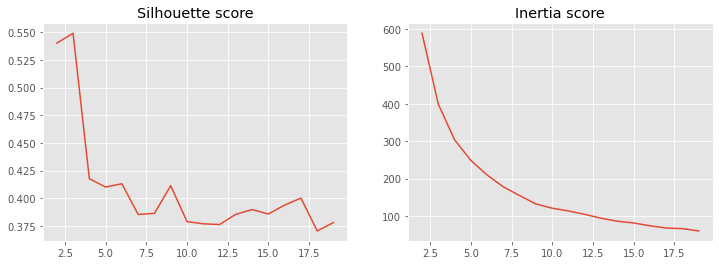

In [80]:
# create clusters based on scaled population and income

popln_income_cluster = popln_income.drop(columns='zip')

ss = StandardScaler()
ss.fit(popln_income_cluster)
group_cluster = ss.transform(popln_income_cluster)

sil_scores = []
inertia_scores = []
for k in range(2, 20):
    kmc = KMeans(n_clusters=k, random_state=2021)
    kmc.fit(group_cluster)
    sil_score = silhouette_score(group_cluster, kmc.labels_)
    sil_scores.append(sil_score)
    inertia_score = kmc.inertia_
    inertia_scores.append(inertia_score)
    
scores_df = pd.DataFrame({
    'k': list(range(2,20)),
    'sil': sil_scores,
    'inertia': inertia_scores
})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(list(range(2, 20)),scores_df['sil'])
ax[0].set_title('Silhouette score')
ax[1].plot(list(range(2, 20)),scores_df['inertia'])
ax[1].set_title('Inertia score')
plt.show()

In [81]:
# set number of clusters to 4 because this looks like the 'elbow'
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2021).fit(group_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 3, 3, 3, 1, 3, 3, 1], dtype=int32)

In [82]:
silhouette_score(group_cluster, kmeans.labels_)

0.4175799079606126

In [83]:
# get silhouette
silhouette_vals = silhouette_samples(group_cluster,kmeans.labels_)

In [84]:
# silhouette plot
y_ticks = []
y_lower = y_upper = 0
fig, ax = plt.subplots(figsize=(7,6))

for i,cluster in enumerate(np.unique(kmeans.labels_)):
   cluster_silhouette_vals = silhouette_vals[kmeans.labels_ ==cluster]
   cluster_silhouette_vals.sort()
   y_upper += len(cluster_silhouette_vals)
   
   ax.barh(range(y_lower,y_upper),
   cluster_silhouette_vals,height =1);
   ax.text(-0.03,(y_lower+y_upper)/2,str(i+1))
   y_lower += len(cluster_silhouette_vals)
       
   # Get the average silhouette score 
   avg_score = np.mean(silhouette_vals)
   ax.axvline(avg_score,linestyle ='--',
   linewidth =2,color = 'green')
   ax.set_yticks([])
   ax.set_xlim([-0.1, 1])
   ax.set_xlabel('Silhouette coefficient values')
   ax.set_ylabel('Cluster labels')
   ax.set_title('Silhouette plot for the various clusters');

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [85]:
# popln_income.insert(0, 'cluster_labels', kmeans.labels_)
popln_income['cluster_labels'] = kmeans.labels_
popln_income.head()

zip  total_pop  median  cluster_labels
0  98001      33699   90287               1
1  98002      33468   57317               1
2  98003      49533   59391               1
3  98004      36202  134580               3
4  98005      19223  120913               3

In [86]:
# add clustering labels to neighborhoods_venues_sorted

def add_cluster_label(value):
    if value in popln_income['zip'].to_list():
        return popln_income[popln_income['zip']==value]['cluster_labels'].to_list()[0]
    else:
        pass

neighborhoods_venues_sorted['cluster_labels'] = neighborhoods_venues_sorted['zip'].apply(add_cluster_label)

In [87]:
neighborhoods_map = neighborhoods_venues_sorted
neighborhoods_map.dropna(inplace=True)
neighborhoods_map['cluster_labels'].value_counts(dropna=False)

1.0    630
3.0    402
0.0    220
2.0    184
Name: cluster_labels, dtype: int64

In [88]:
neighborhoods_map.head()

zip      city  station_latitude  station_longitude 1st Most Common Venue  \
0  98004  Bellevue         47.616971        -122.203009        Clothing Store   
1  98004  Bellevue         47.616865        -122.202993        Clothing Store   
2  98101   Seattle         47.607379        -122.339155    Seafood Restaurant   
3  98004  Bellevue         47.616294        -122.201029        Clothing Store   
4  98004  Bellevue         47.616372        -122.201111        Clothing Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop         Women's Store         Shopping Mall   
1           Coffee Shop                  Café         Shopping Mall   
2           Coffee Shop   American Restaurant             Gift Shop   
3         Shopping Mall         Women's Store                  Café   
4         Shopping Mall         Women's Store                  Café   

  5th Most Common Venue   6th Most Common Venue   7th Most Common Venue  \
0    Seafood Restaurant                   Hotel  Furniture / Home Store   
1         Women's Store  Furniture / Home Store      Seafood Restaurant   
2                Bakery           Boat or Ferry            Cocktail Bar   
3             Juice Bar                     Spa                   Hotel   
4           Coffee Shop                   Hotel                     Spa   

          8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
0                          Café     Electronics Store            Snack Place   
1                         Hotel         Jewelry Store      Electronics Store   
2  Theme Park Ride / Attraction        Clothing Store           Burger Joint   
3        Furniture / Home Store           Coffee Shop     Seafood Restaurant   
4        Furniture / Home Store             Juice Bar     Seafood Restaurant   

   cluster_labels  
0             3.0  
1             3.0  
2             2.0  
3             3.0  
4             3.0

Visualize the clusters. Start the map zoomed into Seattle.

In [89]:
# initialize to None
lat_lng_coords = None

# loop until we get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('Seattle, Washington') # center the map around Seattle
    lat_lng_coords = g.latlng

latitude_wa = lat_lng_coords[0]
longitude_wa = lat_lng_coords[1]

print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude_wa, longitude_wa))

The geograpical coordinate of Seattle are 47.60357000000005, -122.32944999999995.


In [107]:
# create map
map_clusters = folium.Map(width=1000, height=700,location=[latitude_wa, longitude_wa], zoom_start=13)

# create color options
colors = ['red','blue','green','orange']

# add markers to the map
for lat, lon, zipcode, city, cluster in zip(neighborhoods_map['station_latitude'], neighborhoods_map['station_longitude'], neighborhoods_map['zip'], 
                                            neighborhoods_map['city'],neighborhoods_map['cluster_labels']):
    label = folium.Popup(str(zipcode) + ' - Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.5).add_to(map_clusters)
    counter += 1
       
map_clusters

There are strong separations in the clusters, that do not match zipcode separation below (would help improve this comparison, to figure out how to draw zipcode boundaries on the map). Carry out numerical evaluation.
<img src="./images/seattle_zipcodes.png" alt="Seattle Zipcode" style="width: 500px;"/>

## Evaluate cluster decision
Can we find an underlying pattern behind the clusters?

In [100]:
popln_income.groupby(by='cluster_labels').mean()

zip     total_pop         median
cluster_labels                                           
0               98806.634241   2952.241245   48133.739300
1               98439.416058  34534.408759   71746.350365
2               98605.160256   5180.621795   74168.871795
3               98187.854167  23042.562500  126376.541667

In [101]:
popln_income.shape

(598, 4)

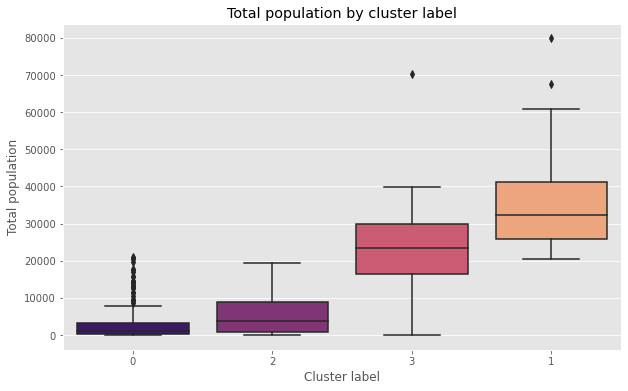

In [102]:
# Boxplot of total population by cluster label

popln_income_plot = popln_income.sort_values(by=['total_pop'])
popln_income_plot['cluster_labels'] = popln_income_plot['cluster_labels'].astype(str)

plt.figure(figsize=(10, 6))
sns.boxplot(y='total_pop', x='cluster_labels', 
                 data=popln_income_plot, 
                 palette="magma")
plt.title('Total population by cluster label')
plt.xlabel('Cluster label')
plt.ylabel('Total population')
plt.show()

In [103]:
# Boxplot of median income by cluster label

popln_income_plot = popln_income.sort_values(by=['median'])
popln_income_plot['cluster_labels'] = popln_income_plot['cluster_labels'].astype(str)

plt.figure(figsize=(10, 6))
sns.boxplot(y='median', x='cluster_labels', 
                 data=popln_income_plot, 
                 palette="viridis")
plt.title('Median income by cluster label')
plt.xlabel('Cluster label')
plt.ylabel('Median income')
plt.show()

Clusters seem to correlate with median population more strongly, with a bit of fuzziness in correlation with median income.

## Calculate Distances Between Charging Stations
Use Haversine distance

In [112]:
# uncomment to load presaved data instead of running next 4 cells (takes ~30 minutes)
# stations_dist = pd.read_csv('./Data/stations_dist.csv')
# stations_dist.to_csv('./Data/stations_dist.csv', index=False)

In [104]:
longitude = list(stations['longitude'])
latitude = list(stations['latitude'])

In [106]:
# calculate pairwise-distance (Haversine), and save the 2 smallest
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude/43211266#43211266

dist_list1 = []
dist_list2 = []
for ind in range(stations.shape[0]):
    dist_sublist = []
    coords_1 = (latitude[ind], longitude[ind])
    for i in range(stations.shape[0]):
        coords_2 = (latitude[i], longitude[i])
        dist_sublist.append(distance.distance(coords_1, coords_2).miles)
    dist_sublist = np.sort(dist_sublist)
    dist_list1.append(dist_sublist[1])
    dist_list2.append(dist_sublist[2])

In [108]:
col_names = ['station_name','zip','city','latitude','longitude','open_date']
stations_dist = stations[col_names].copy()
stations_dist['nearest_dist1'] = dist_list1
stations_dist['nearest_dist2'] = dist_list2

In [109]:
# group all stations that have at least 1 other station within 3 miles of itself as 'is_really_far'
dist_cutoff = 3
stations_dist['is_far1'] = [1 if val > dist_cutoff else 0 for val in stations_dist['nearest_dist1']]
stations_dist['is_far2'] = [1 if val > dist_cutoff else 0 for val in stations_dist['nearest_dist2']]

def is_really_far(row):
#     print(vals)
    if  row['is_far1']==1 or row['is_far2']==1:
        return 1
    else:
        return 0
    
stations_dist['is_really_far'] = stations_dist.apply(is_really_far,axis=1)
stations_dist = stations_dist.sort_values(by='nearest_dist2')
stations_dist.reset_index(inplace=True, drop=True)
stations_dist['is_really_far'].value_counts(normalize=True)

0    0.915528
1    0.084472
Name: is_really_far, dtype: float64

In [110]:
# initialize to None
lat_lng_coords = None

# loop until we get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('Ellensburg, Washington') # I want the WA map to be centered on the middle of WA state again
    lat_lng_coords = g.latlng

latitude_wa = lat_lng_coords[0]
longitude_wa = lat_lng_coords[1]

print('The geograpical coordinate of Ellensburg, WA are {}, {}.'.format(latitude_wa, longitude_wa))

The geograpical coordinate of Ellensburg, WA are 46.99703000000005, -120.54871999999995.


Circle for each zipcode, colored by 'above_med'.

In [127]:
map_wa = folium.Map(width=1000, height=700,location=[latitude_wa, longitude_wa], zoom_start=7, control_scale=True)

circle_color = ['red','blue']
tail = stations_dist.tail(20).reset_index(drop=True)
tail.head(20)

for ind in range(stations_dist.shape[0]):
    lat = stations_dist.loc[ind,'latitude']
    lng = stations_dist.loc[ind,'longitude']
    color_val = stations_dist.loc[ind,'is_really_far']
    
    folium.CircleMarker(
    [lat,lng],
#     radius = ev_by_zip.loc[ind,'model']/70,
    radius = 5,
    color=circle_color[color_val], # red if is_really_far == 0
    fill=True,
    fill_color=circle_color[color_val],
    fill_opacity=0.5).add_to(map_wa)
    
map_wa

This looks like a good way to create distance-based clusters. Or rural vs urban clusters.

## Driving Distance-Based inter-station separation
Are there enough stations to cover long-distance trips? Compare with Norway, which has 2 fast charging stations every 30 miles. 

#### What are some of the larger distances between charging stations?
Suggestion: large distances makes it impractical for EV use for long drives.

In [115]:
# try out Open Street Map OSMR API to get driving distance
lat1 = 47.298000
lng1 = -122.248500
lat2 = 47.293477
lng2 = -122.212944

r = requests.get(f"http://router.project-osrm.org/route/v1/car/{lng1},{lat1};{lng2},{lat2}?overview=false""")
# then you load the response using the json libray
# by default you get only one alternative so you access 0-th element of the `routes`
routes = json.loads(r.content)
route_1 = routes.get("routes")[0]
route_1['distance']*0.000621371192 # distance in meters converted to miles

3.1527131539696

In [118]:
# uncomment to load presaved data instead of running next 4 cells (~1hr to run)
# stations_far.to_csv('./Data/stations_drive_far.csv', index=False)
# stations_far = pd.read_csv('./Data/stations_drive_far.csv')

In [117]:
# just pick out stations that are really far, but not out on an island
stations_far = stations_dist[stations_dist['is_really_far']==1]
stations_far = stations_far[(stations_far['nearest_dist1']<1000) & (stations_far['nearest_dist2']<1000)]
stations_far.reset_index(inplace=True, drop=True)
stations_far.head(2)

station_name    zip      city   latitude   longitude open_date  \
0       STCU Valley  99216   Spokane  47.628186 -117.227256       NaN   
1  Light House Park  98275  Mukilteo  47.948755 -122.306201       NaN   

   nearest_dist1  nearest_dist2  is_far1  is_far2  is_really_far  
0       2.821179       3.112073        0        1              1  
1       3.051269       3.116998        1        1              1

In [886]:
longitude = list(stations_far['longitude'])
latitude = list(stations_far['latitude'])

In [892]:
# calculate driving distance, and save the 2 smallest
# https://towardsdatascience.com/driving-distance-between-two-or-more-places-in-python-89779d691def#1c17

drive_list1 = []
drive_list2 = []
for ind in range(stations_far.shape[0]):
    # instantiate empty list
    dist_sublist = []
    
    # origin coordinate
    lat1 = latitude[ind]
    lng1 = longitude[ind]
#     lat1 = 47.31711
#     lat2 = -119.553158

    # calculate distance for all coordinate pairs
    for i in range(stations_far.shape[0]):
        lat2 = latitude[i]
        lng2 = longitude[i]
#         lat2 = lat1
#         lng2 = lng1
        
        r = requests.get(f"http://router.project-osrm.org/route/v1/car/{lng1},{lat1};{lng2},{lat2}?overview=false""")
        # then you load the response using the json libray
        # by default you get only one alternative so you access 0-th element of the `routes`
        routes = json.loads(r.content)
        route_1 = routes.get("routes")[0]
        dist_sublist.append(route_1['distance']*0.000621371192) # distance in meters converted to miles
    
    # sort dist_sublist
    dist_sublist = np.sort(dist_sublist)
    
    # append 2 shortest distances to drive_list
    try:
        drive_list1.append(dist_sublist[1])
    except:
        drive_list1.append(dist_sublist[0])
        
    try:    
        drive_list2.append(dist_sublist[2])
    except:
        drive_list2.append(dist_sublist[0])
        
    if ind%5==0:
        print(f'Completed {ind} locations')

Completed 0 locations
Completed 5 locations
Completed 10 locations
Completed 15 locations
Completed 20 locations
Completed 25 locations
Completed 30 locations
Completed 35 locations
Completed 40 locations
Completed 45 locations
Completed 50 locations
Completed 55 locations
Completed 60 locations
Completed 65 locations
Completed 70 locations
Completed 75 locations
Completed 80 locations
Completed 85 locations
Completed 90 locations
Completed 95 locations
Completed 100 locations
Completed 105 locations
Completed 110 locations
Completed 115 locations
Completed 120 locations
Completed 125 locations
Completed 130 locations


In [893]:
stations_far['nearest_drive1'] = drive_list1
stations_far['nearest_drive2'] = drive_list2
stations_far.sort_values(by='nearest_drive1',ascending=False,inplace=True)
stations_far.head()

station_name    zip       city   latitude  \
111                     Port of Clarkston  99403  Clarkston  46.425498   
39                                 Yakima  98901     Yakima  46.677586   
127                               Connell  99326    Connell  46.659028   
123                    Rosalia - E 6th St  99170    Rosalia  47.234673   
132  Ferry County Public Utility District  99166   Republic  48.646980   

      longitude   open_date  nearest_dist1  nearest_dist2  is_far1  is_far2  \
111 -117.048650         NaN      20.830263      21.631410        1        1   
39  -120.479130         NaN       5.067715       5.098610        1        1   
127 -118.861158         NaN      28.987343      28.995868        1        1   
123 -117.370063         NaN      26.182547      26.211801        1        1   
132 -118.737542  2016-10-15      32.326607      37.727349        1        1   

     is_really_far  nearest_drive1  nearest_drive2  
111              1       66.664803       67.790603  
39               1       47.590198       51.895803  
127              1       44.469921       47.992909  
123              1       42.702990       43.280803  
132              1       40.291634       52.181448

In [119]:
stations_far['is_really_far'].value_counts()

1    135
Name: is_really_far, dtype: int64

In [120]:
# Use the Norwegian 30-mile cutoff standard
drive_cutoff = 30
stations_far['far_drive1'] = [1 if val > drive_cutoff else 0 for val in stations_far['nearest_drive1']]
stations_far['far_drive2'] = [1 if val > drive_cutoff else 0 for val in stations_far['nearest_drive2']]

def is_really2_far(row):
#     print(vals)
    if  row['far_drive1']==1 or row['far_drive2']==1:
        return 1
    else:
        return 0
    
stations_far['is_really2_far'] = stations_far.apply(is_really2_far,axis=1)
stations_far = stations_far.sort_values(by='nearest_drive2')
stations_far.reset_index(inplace=True, drop=True)
stations_far['is_really2_far'].value_counts(normalize=True)

0    0.785185
1    0.214815
Name: is_really2_far, dtype: float64

In [126]:
stations_far.tail(20)

station_name    zip        city  \
115                 Adytum Sanctuary - Tesla Destination  98564   Mossyrock   
116                     Hotel Cathlamet Rear Parking Lot  98612   Cathlamet   
117                  Hotel Cathlamet - Tesla Destination  98612   Cathlamet   
118                                     Pend Oreille PUD  99156     Newport   
119                       City of Bridgeport - City Hall  98813  Bridgeport   
120                                             Omak Inn  98841        Omak   
121                              Highway 2 Brew Espresso  98858  Waterville   
122                                   Rosalia - E 6th St  99170     Rosalia   
123                                Lincoln County Museum  99122   Davenport   
124                                              Connell  99326     Connell   
125                                   Colville City Hall  99114    Colville   
126                                     City of Colville  99114    Colville   
127                                               Yakima  98901      Yakima   
128                 Ferry County Public Utility District  99166    Republic   
129             Hobuck Beach  Resort - Tesla Destination  98357    Neah Bay   
130  Hobuck Beach Resort  RV Camping - Tesla Destination  98357    Neah Bay   
131                                Lakeside 24 Hour Fuel  98616      Cougar   
132       Carson Ridge Luxury Cabins - Tesla Destination  98610      Carson   
133                   Skamania Lodge - Tesla Destination  98648   Stevenson   
134                                    Port of Clarkston  99403   Clarkston   

      latitude   longitude   open_date  nearest_dist1  nearest_dist2  is_far1  \
115  46.544781 -122.510619  2017-09-01      23.582615      24.087923        1   
116  46.202576 -123.384169         NaN       0.006084      21.711719        0   
117  46.202490 -123.384200  2018-10-01       0.006084      21.712032        0   
118  48.181765 -117.043496         NaN      25.966552      30.862053        1   
119  48.009356 -119.672953  2017-04-01      10.990660      19.821431        1   
120  48.421424 -119.503978  2013-10-04      19.863784      28.705415        1   
121  47.649002 -120.070865  2020-08-24       6.814671      12.865801        1   
122  47.234673 -117.370063         NaN      26.182547      26.211801        1   
123  47.652922 -118.150361  2016-10-01      22.603795      27.517263        1   
124  46.659028 -118.861158         NaN      28.987343      28.995868        1   
125  48.543915 -117.904797         NaN       0.114778      38.826470        0   
126  48.545492 -117.905583         NaN       0.114778      38.770617        0   
127  46.677586 -120.479130         NaN       5.067715       5.098610        1   
128  48.646980 -118.737542  2016-10-15      32.326607      37.727349        1   
129  48.340037 -124.663540  2015-10-01       0.501465      29.867744        0   
130  48.333226 -124.659779  2015-11-01       0.501465      29.373391        0   
131  46.051228 -122.301754  2014-03-06      23.726713      23.901494        1   
132  45.729351 -121.821302  2016-06-01       5.097674      32.110758        1   
133  45.685326 -121.905864  2016-04-01       5.097674      28.107954        1   
134  46.425498 -117.048650         NaN      20.830263      21.631410        1   

     is_far2  is_really_far  nearest_drive1  nearest_drive2  far_drive1  \
115        1              1       31.646311       33.978627           1   
116        1              1        0.008264       35.944708           0   
117        1              1        0.008264       35.952972           0   
118        1              1       30.933225       36.932999           1   
119        1              1       17.190048       37.060566           0   
120        1              1       22.317230       37.060566           0   
121        1              1       27.585526       39.394934           0   
122        1              1       42.702990       43.280803           1   
123    

In [122]:
map_wa = folium.Map(width=1000, height=700,location=[latitude_wa, longitude_wa], zoom_start=7, control_scale=True)

circle_color = ['red','blue','black']

for ind in range(stations_dist.shape[0]):
    lat = stations_dist.loc[ind,'latitude']
    lng = stations_dist.loc[ind,'longitude']
    color_val = stations_dist.loc[ind,'is_really_far']
    
    if color_val == 0:
        folium.CircleMarker(
        [lat,lng],
        radius = 5,
        color=circle_color[color_val], # red if is_really_far == 0
        fill=True,
        fill_color=circle_color[color_val],
        fill_opacity=0.5).add_to(map_wa)
    else:
        pass

for ind in range(stations_far.shape[0]):
    lat = stations_far.loc[ind,'latitude']
    lng = stations_far.loc[ind,'longitude']
    color_val = stations_far.loc[ind,'is_really2_far']

    folium.RegularPolygonMarker(
    [lat,lng],
#     radius = ev_by_zip.loc[ind,'model']/70,
    radius = 5,
    color=circle_color[color_val+1], # blue if is_really2_far == 0
    fill=True,
    fill_color=circle_color[color_val+1],
    fill_opacity=0.5).add_to(map_wa)
    
map_wa

Some black diamonds look like they're less than 30 miles from the next charging station. And some blue diamonds look like they're less than 3 miles from the next closest charging station. This might be because we checked for driving distance just for the 'is_really_far' stations so pair-wise distances were just being checked for inter-far stations. With time, would redo with all stations (takes a long time).

### Consider Driving Seattle to Spokane
There are clusters or stations in between Seattle and Spokane, but some distances between clusters are larger than 30 miles (refer the scalebar at the bottom of the map).

## Testing for Streamlit
Help businesses identify whether or not there are other stations around them (in WA state)

In [113]:
def biz_station(stations_dist, geolocator, usr_lat, usr_lng):
    
    # get zipcode from (lat,lng)
    location = geolocator.reverse((usr_lat, usr_lng))
    zipcode = int(location.raw['address']['postcode'])
    
    # df of all stations in that zipcode
    df_zip = stations_dist[stations_dist['zip']==zipcode].copy()
    
    df_lat = list(df_zip['latitude'])
    df_lng = list(df_zip['longitude'])
    
    # calculate all distance pairs
    usr_dist = []
    coords_1 = (usr_lat, usr_lng)
    for ind in range(df_zip.shape[0]):
        coords_2 = (df_lat[ind],df_lng[ind])
        usr_dist.append(distance.distance(coords_1, coords_2).miles)
    
    # sort distance pairs
    usr_dist = np.sort(usr_dist)
    
    # count number of distance pairs <0.2 miles
    count_close_by = sum(1 for i in usr_dist if i < 0.2)
    
    if count_close_by > 3:
        # not many charging stations close by
        return False
    else:
        # too many charging stations close by
        return True

In [114]:
# Somewhere in Seattle: lat: 47.618696, lng: -122.191787

geolocator = Nominatim(user_agent='my_application')

usr_lat = float(input("Enter the latitude: "))
usr_lng = float(input("Enter the longitude: "))

decision = biz_station(stations_dist, geolocator, usr_lat, usr_lng)
print('')

if decision:
    print(f'There are more than 3 charging stations within a 0.2 mile radius.')
else:
    print(f'Go ahead and build a charging station! There are less than 3 charging stations within a 0.2 mile radius.')

Enter the latitude:  47.618696
Enter the longitude:  -122.191787



Go ahead and build a charging station! There are less than 3 charging stations within a 0.2 mile radius.
